In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from tqdm import tqdm

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve

First, I load the clean dataset I made in the first notebook

In [5]:
df=pd.read_csv('loans_clean_before_dummy.csv')

I select a subset with only the state of **California** and the **Real Estate** sector: the same subset as in the article.

In [6]:
df2=df.loc[(df.NAICS_sector=='real_estate')&(df.State=='CA')].copy()

In [7]:
df2.drop(['State','NAICS_sector'], axis=1, inplace=True)

In [8]:
df2=pd.get_dummies(df2,columns=['retain_create'])

In [9]:
df2.shape

(2105, 11)

In [10]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2105 entries, 539 to 862646
Data columns (total 11 columns):
GrAppv                            2105 non-null float64
Is_RevLineCr                      2105 non-null float64
Is_CHGOFF                         2105 non-null float64
Is_New                            2105 non-null float64
NoEmp_150                         2105 non-null float64
Is_RealEstate                     2105 non-null float64
SBA_portion                       2105 non-null float64
Is_Recession_08                   2105 non-null int64
retain_create_create_no_retain    2105 non-null uint8
retain_create_no_job              2105 non-null uint8
retain_create_retain_job          2105 non-null uint8
dtypes: float64(7), int64(1), uint8(3)
memory usage: 154.2 KB


### Variable selection using Mutual Information

I have already created and selected features in the first notebook. Now I will use Mutual Information between the variables and the target (Is_CHGOFF), to further reduce the number of variables as inputs in the model

In [11]:
from sklearn.feature_selection import mutual_info_classif

In [12]:
X = df2.drop('Is_CHGOFF',axis=1)
y = df2.Is_CHGOFF

In [13]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X,y, random_state=42, test_size=0.2, stratify=y)

In [14]:
mut_info_results = pd.DataFrame([X_train_val.columns,mutual_info_classif(X_train_val,y_train_val)]).T

In [15]:
mut_info_results.sort_values(by=1,ascending =False,inplace=True)

In [16]:
mut_info_results

,0,1
0,GrAppv,0.104256
5,SBA_portion,0.0928985
4,Is_RealEstate,0.0756425
1,Is_RevLineCr,0.0372376
9,retain_create_retain_job,0.0334634
7,retain_create_create_no_retain,0.0280202
3,NoEmp_150,0.0218414
2,Is_New,0
6,Is_Recession_08,0
8,retain_create_no_job,0


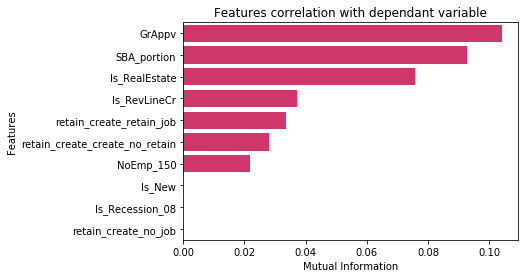

In [17]:
sns.barplot(x=1, y=0,data = mut_info_results, color='#E91D63')
plt.xlabel('Mutual Information')
plt.ylabel('Features')
plt.title('Features correlation with dependant variable')
plt.savefig('images/MI.svg', format='svg')
plt.savefig('images/MI.png', format='png')
plt.show()

We will only keep the top 3 features:
- SBA_portion
- GrAppv
- Is_RealEstate

In the article, they keep: 
- SBA_portion
- DisbursementGross (instead of GrAppv, which we saw was mostly the same values, but with missing values) 
- Is_RealEstate
- Is_New (which they eliminate in the final model) 
- and Is_Recession (which is not defined like mine: their feature indicate whether the end of the loan (beginning + term) is in the Recession period; mine indicates whether the beginning of the loan is in the Recession period (see README and first notebook)

In [18]:
var_select = ['GrAppv','SBA_portion','Is_RealEstate']

In [19]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate

In [20]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [21]:
#!pip install --user imbalanced-learn

In [22]:
import imblearn
print(imblearn.__version__)

0.7.0


In [23]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

I will first select an algorithm among a few classical ones.

The metric I choose to compare the models is the **ROC-AUC score**:
it is the average of recall (which is an important metric in this project, since False Negative cost more than False Positive) and Specificity. This will prevent the model from choosing to classify all loans as Positive (rejecting all loans will not help earn money)

In [24]:
ratio = sum(y==0)/sum(y==1)

In [25]:
ratio

2.007142857142857

In [22]:
# (same ratio for the whole dataset, the train set and the test set because of the 'stratify=y' param)

The data is imbalanced: I will use SMOTE to oversample the positive class (Is_CHGOFF = 1).

I will also standardize the features (since some of the algorithms (Logistic Regression, KNN...) require standardization.

In [27]:
models = [LogisticRegression(random_state=0), 
          KNeighborsClassifier(), 
          svm.SVC(kernel='linear', random_state=0),
          svm.SVC(kernel='poly', degree = 2, random_state=0),
          svm.SVC(kernel='poly', degree = 3, random_state=0),
          svm.SVC(kernel='sigmoid', random_state=0),
          svm.SVC(kernel='rbf', random_state=0), 
          DecisionTreeClassifier( random_state=0), 
          RandomForestClassifier(n_estimators=100, random_state=0),
          RandomForestClassifier(n_estimators=300, random_state=0),
          xgb.XGBClassifier( random_state=0) ]

In [28]:
model_names = ['logReg', 
               'KNN', 
               'SVM_lin',
               'SVM_poly2',
               'SVM_poly3',
               'SVM_sigmoid',
               'SVM_rbf', 
               'DT', 
               'RF_100',
               'RF_300',
               'xgb' ]

In [29]:
cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=3, random_state=1)

In [30]:
restart = 0
lst = []

In [33]:
for name, model in tqdm(list(zip(model_names[restart:],models[restart:]))):
    steps = [('over',SMOTE()),('s',StandardScaler()), ('m',model)]
    pipeline = Pipeline(steps=steps)
    m_scores = cross_validate(pipeline, X_train_val[var_select], y_train_val, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
    lst.append([name,
                np.mean(m_scores['test_score'])])
    np.savez('model_selection', lst = lst)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:08<00:00,  1.18s/it]


In [34]:
results = pd.DataFrame(lst,columns=['model','roc_auc'])

In [35]:
results.sort_values(by=['roc_auc'], ascending=False)

,model,roc_auc
10,xgb,0.778244
6,SVM_rbf,0.753444
9,RF_300,0.750664
8,RF_100,0.748277
1,KNN,0.729567
3,SVM_poly2,0.729315
4,SVM_poly3,0.728029
7,DT,0.718447
0,logReg,0.712364
2,SVM_lin,0.709138


XGboost has the best score, I choose this algorithm.
Note that Logistic Regression (the algorithm used in the article) gives a much lower roc_auc score. XGboost is known to be one of the algorithms that performs the best on a large variety of projects.

## Hyperparam tuning for XGBoost Classifier

In [36]:
from sklearn.model_selection import RandomizedSearchCV

XGBoost is a tree based algorithm, Standardization is not necessary, so I will not use it.

I choose to not use SMOTE and instead adress the imbalance issue with the scale_pos_weight parameter of the XGB Classifier.

In [41]:
model = xgb.XGBClassifier(scale_pos_weight=ratio, random_state=0)

In [42]:
from scipy.stats import uniform, randint

In [43]:
params={
    'booster':['gbtree', 'dart'],
    'colsample_bytree': uniform(0.6,0.4),
    'gamma': uniform(0,0.5),
    'learning_rate': uniform(0.001,0.3),
    'max_depth': randint(2,20),
    'n_estimators': randint(50,300),
    'subsample':uniform(0.5,0.5)
}

In [73]:
%%time
rsearch = RandomizedSearchCV(estimator=model, cv=5,
                        param_distributions=params,n_iter=300, scoring='roc_auc')
rsearch.fit(X_train_val[var_select], y_train_val)

Wall time: 15min 28s


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(scale_pos_weight=2.007142857142857),
                   n_iter=300,
                   param_distributions={'booster': ['gbtree', 'dart'],
                                        'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000028970125D30>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000289701252B0>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002897011B550>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002897011BBA8>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002897011BE80>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002897011BF28>},
        

In [74]:
rsearch.best_params_

{'booster': 'gbtree',
 'colsample_bytree': 0.7382121128933288,
 'gamma': 0.1605554352734253,
 'learning_rate': 0.03485734006993313,
 'max_depth': 4,
 'n_estimators': 119,
 'subsample': 0.9755827535312728}

In [75]:
rsearch.best_score_

0.785110827664399

In [76]:
y_pred = rsearch.best_estimator_.predict(X_test[var_select])

In [77]:
accuracy_score(y_test,y_pred)

0.7292161520190024

In [78]:
precision_score(y_test,y_pred)

0.5596330275229358

In [79]:
recall_score(y_test,y_pred)

0.8714285714285714

In [80]:
confusion_matrix(y_test,y_pred)

array([[185,  96],
       [ 18, 122]], dtype=int64)

In [81]:
roc_auc_score(y_test,y_pred)

0.7648957803762074

In [82]:
yhat=rsearch.best_estimator_.predict_proba(X_test[var_select])

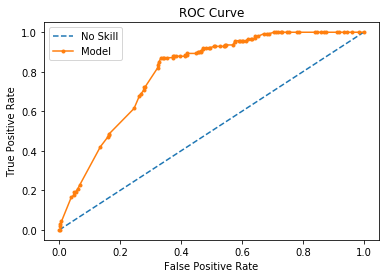

In [83]:
# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]
# plot no skill roc curve
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
# calculate roc curve for model
fpr, tpr, _ = roc_curve(y_test, pos_probs)
# plot model roc curve
plt.plot(fpr, tpr, marker='.', label='Model')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
# show the legend
plt.legend()
# show the plot
plt.savefig('images/ROC.svg', format='svg')
plt.savefig('images/ROC.png', format='png')
plt.show()

In [84]:
def plot_cm(y_true, y_pred, labels, path, figsize=(10,10)):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm_perc = pd.DataFrame(cm_perc, index=labels, columns=labels)
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm_perc,  annot=annot, fmt='', ax=ax, vmax=100)
    fig.suptitle('Confusion matrix', fontsize=14)
    plt.xlabel('Predicted Label',fontsize=12)
    plt.ylabel('True Label',fontsize=12)
    plt.savefig(path+'.svg', format='svg')
    plt.savefig(path+'.png', format='png')

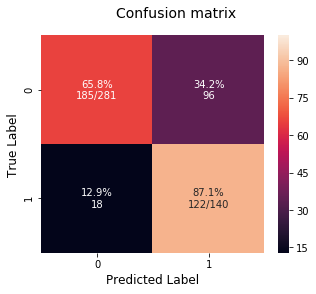

In [85]:

plot_cm(y_test, y_pred, [0,1], 'images/conf_mat', figsize=(5,4))